In [1]:

import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold


import numpy as np
import pandas as pd
import sys

from polyssifier import poly

import logging 

import scipy.sparse as sp
import scipy.io
from scipy.stats import zscore
from scipy.signal import detrend

from scipy.sparse.linalg import eigs
from gunfolds.utils import graphkit as gk
from gunfolds.conversions import graph2adj

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.impute import SimpleImputer


from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

In [2]:

def check_matrix_powers(W, A, powers, threshold):
    for n in powers:
        W_n = np.linalg.matrix_power(W, n)
        non_zero_indices = np.nonzero(W_n)
        if (np.abs(W_n[non_zero_indices]) < threshold).any():
            return False
    return True


def create_stable_weighted_matrix(
    A,
    threshold=0.1,
    powers=[1, 2, 3, 4],
    max_attempts=1000,
    damping_factor=0.99,
    random_state=None,
):
    np.random.seed(
        random_state
    )  # Set random seed for reproducibility if provided
    attempts = 0

    while attempts < max_attempts:
        # Generate a random matrix with the same sparsity pattern as A
        random_weights = np.random.randn(*A.shape)
        weighted_matrix = A * random_weights

        # Convert to sparse format for efficient eigenvalue computation
        weighted_sparse = sp.csr_matrix(weighted_matrix)

        # Compute the largest eigenvalue in magnitude
        eigenvalues, _ = eigs(weighted_sparse, k=1, which="LM")
        max_eigenvalue = np.abs(eigenvalues[0])

        # Scale the matrix so that the spectral radius is slightly less than 1
        if max_eigenvalue > 0:
            weighted_matrix *= damping_factor / max_eigenvalue
            # Check if the powers of the matrix preserve the threshold for non-zero entries of A
            if check_matrix_powers(weighted_matrix, A, powers, threshold):
                return weighted_matrix

        attempts += 1

    raise ValueError(
        f"Unable to create a matrix satisfying the condition after {max_attempts} attempts."
    )


def drawsamplesLG(A, nstd, samples):
    n = A.shape[0]
    data = np.zeros([n, samples])
    data[:, 0] = nstd * np.random.randn(A.shape[0])
    for i in range(1, samples):
        data[:, i] = A @ data[:, i - 1] + nstd * np.random.randn(A.shape[0])
    return data


def genData(A, rate=2, burnin=100, ssize=5000, nstd=0.1):
    Agt = A.copy()
    data = drawsamplesLG(Agt, samples=burnin + (ssize * rate), nstd=nstd)
    data = data[:, burnin:]
    return data[:, ::rate]

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


#Step 0: Iterate through values for nstd, burnin, noise_svar
nstd = 1.0
burn = 100
threshold = 0.0001

NOISE_SIZE = 2961*2
NUM_SUBS = 10
subjects = ['20150210', '20150417', '20150428', '20151110', '20151127', 
            '20150410', '20150421', '20151030', '20151117', '20151204']

num_graphs = 1
num_noise = 2
n_folds = 4
n_threads= 12

graph_ix = 1002
graph_dir = '/data/users2/jwardell1/nshor_docker/examples/oulu-project/OULU/g4.pkl'
g = np.load(graph_dir, allow_pickle=True)
A = graph2adj(g)
u_rate = 1
logging.info(f'\t\t\t\tGraph Number {graph_ix} of {num_graphs}')

#SNR = 1

SNRs = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0]

2024-05-10 01:07:37,100 - INFO - 				Graph Number 1002 of 1


In [4]:
num_converged = 0
converged_subjects = []
noises = dict()
while num_converged < NUM_SUBS:
    for subject in subjects:
        if subject in converged_subjects:
            continue

        try:
            W = create_stable_weighted_matrix(A, threshold=threshold, powers=[2])
            var_noise = genData(W, rate=u_rate, burnin=burn, ssize=NOISE_SIZE, nstd=nstd)
            var_noise = zscore(var_noise, axis=1)
            noises[subject] = var_noise 
            num_converged += 1
            converged_subjects.append(subject)

        except Exception as e:
            print(e)
            logging.info(f'num converged: {num_converged}')
            
noises

2024-05-10 01:07:38,626 - INFO - num converged: 5


ARPACK error -1: No convergence (531 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]


{'20150210': array([[ 0.96523052,  0.11706522, -0.60111841, ..., -0.6004618 ,
         -1.24275655, -1.31726937],
        [-0.0611239 ,  0.6948859 , -1.06312822, ...,  1.53433348,
          1.38743176,  0.70022947],
        [ 0.78228379, -0.98418691, -0.97599719, ...,  1.26843632,
          0.62741183,  0.71360895],
        ...,
        [ 0.04181113,  1.70706045, -1.36005822, ...,  0.74051834,
          1.69972131,  0.70298801],
        [ 1.02153002, -1.27362191, -1.03219213, ...,  1.42795602,
          0.91441272,  0.827578  ],
        [-1.29091492, -0.93345637, -0.29171301, ...,  0.89466384,
          0.78767965,  1.23216312]]),
 '20150417': array([[ 1.92193654, -0.60603267,  0.66832531, ..., -0.5782606 ,
         -0.88207484,  0.16229742],
        [-0.90720167,  0.69730907, -1.11131585, ...,  0.61194429,
          0.10081867,  0.45571196],
        [ 0.2530732 ,  0.36562558,  0.21860236, ...,  0.33827881,
          0.58874899,  1.97621838],
        ...,
        [-1.07395152,  1.25899

In [5]:
all_data = []

with open('/data/users2/jwardell1/undersampling-project/OULU/txt-files/allsubs_TCs.txt', 'r') as tc_data:
    lines = tc_data.readlines()

for i in range(0, len(lines), 2):
    subject = subjects[i//2]
    logging.info(f'loading TC for subject {subject}')
    filepath_sr1 = lines[i].strip()
    filepath_sr2 = lines[i+1].strip()
    try:
        sr1 = scipy.io.loadmat(filepath_sr1)['TCMax']
        sr2 = scipy.io.loadmat(filepath_sr2)['TCMax']
    
    except:
        continue

    if sr1.shape[0] != 53:
        sr1 = sr1.T

    if sr2.shape[0] != 53:
        sr2 = sr2.T
    
    if sr1.shape[1] < sr2.shape[1]:
        tr100_tc = sr2
        tr2150_tc = sr1
    else:
        tr100_tc = sr1
        tr2150_tc = sr2

    logging.info(f'subject {subject} tr100_tc.shape - {tr100_tc.shape}')
    logging.info(f'subject {subject} tr2150_tc.shape - {tr2150_tc.shape}')

    tr100_tc_zs = zscore(tr100_tc, axis=1)
    tr2150_tc_zs = zscore(tr2150_tc, axis=1)

    tr100_tc_zs_dt = detrend(tr100_tc_zs, axis=1)
    tr2150_tc_zs_dt = detrend(tr2150_tc_zs, axis=1)

    noise_tr100 = noises[subject][:,::2]#/2 #####DEBUG TODO: check later
    noise_tr2150 = noises[subject][:,::33]

    #tr100_tc_zs_dt_noise = tr100_tc_zs_dt+noise_tr100
    #tr2150_tc_zs_dt_noise = tr2150_tc_zs_dt+noise_tr2150

    all_data.append({'Subject_ID'             : str(subject), 
                    'VAR_Noise'               : noises[subject], 
                    'TR100_Noise'             : noise_tr100, 
                    'TR2150_Noise'            : noise_tr2150, 
                    'TR100_Timecourse'        : tr100_tc_zs_dt, 
                    'TR2150_Timecourse'       : tr2150_tc_zs_dt, 
                    #'TR100_Timecourse_Noise'  : tr100_tc_zs_dt_noise, 
                    #'TR2150_Timecourse_Noise' : tr2150_tc_zs_dt_noise
                    })
    
data_df = pd.DataFrame(all_data)

data_df

2024-05-10 01:07:39,991 - INFO - loading TC for subject 20150210
2024-05-10 01:07:40,006 - INFO - subject 20150210 tr100_tc.shape - (53, 2961)
2024-05-10 01:07:40,007 - INFO - subject 20150210 tr2150_tc.shape - (53, 180)
2024-05-10 01:07:40,102 - INFO - loading TC for subject 20150417
2024-05-10 01:07:40,126 - INFO - subject 20150417 tr100_tc.shape - (53, 2961)
2024-05-10 01:07:40,127 - INFO - subject 20150417 tr2150_tc.shape - (53, 180)
2024-05-10 01:07:40,202 - INFO - loading TC for subject 20150428
2024-05-10 01:07:40,226 - INFO - subject 20150428 tr100_tc.shape - (53, 2961)
2024-05-10 01:07:40,227 - INFO - subject 20150428 tr2150_tc.shape - (53, 180)
2024-05-10 01:07:40,311 - INFO - loading TC for subject 20151110
2024-05-10 01:07:40,335 - INFO - subject 20151110 tr100_tc.shape - (53, 2961)
2024-05-10 01:07:40,336 - INFO - subject 20151110 tr2150_tc.shape - (53, 180)
2024-05-10 01:07:40,430 - INFO - loading TC for subject 20151127
2024-05-10 01:07:40,454 - INFO - subject 20151127 t

,Subject_ID,VAR_Noise,TR100_Noise,TR2150_Noise,TR100_Timecourse,TR2150_Timecourse
0,20150210,"[[0.9652305228264665, 0.11706521853715046, -0....","[[0.9652305228264665, -0.6011184090027355, 0.9...","[[0.9652305228264665, 1.3700845960543826, -0.0...","[[-0.04384497970934796, -1.1089141040646802, -...","[[0.6886887100527853, -0.49795380956891466, -0..."
1,20150417,"[[1.9219365383391516, -0.6060326725975983, 0.6...","[[1.9219365383391516, 0.6683253079259956, -0.4...","[[1.9219365383391516, -0.5826270015296703, -0....","[[-0.1607202925005835, -0.8571620023770684, -0...","[[-3.4277492842723736, -1.2679357539105018, 0...."
2,20150428,"[[1.8434805788628843, -0.37458734342891103, -0...","[[1.8434805788628843, -0.4921013867008425, 0.1...","[[1.8434805788628843, -0.21307945801907882, 1....","[[-0.23731891151139628, -0.9356178523703165, -...","[[-6.277579290892412, -3.1454145826612776, -1...."
3,20151110,"[[1.066045222996057, -0.007094781837214368, 2....","[[1.066045222996057, 2.0533006969810232, -0.03...","[[1.066045222996057, -2.3122535077304174, 0.30...","[[0.041609048840367646, -1.0327117238148629, -...","[[-1.7756207977992478, -0.5414674717187071, 0...."
4,20151127,"[[0.7471676859951035, -1.2317958712280896, -2....","[[0.7471676859951035, -2.6034555294163053, 0.0...","[[0.7471676859951035, -1.2435805842200909, 1.2...","[[0.4715334566403786, 0.8085277405442564, 0.57...","[[-0.5468216084070829, 0.8562373936238572, 1.6..."
5,20150410,"[[0.6538410752821635, -1.5403267689427838, -0....","[[0.6538410752821635, -0.7123858833588805, 0.8...","[[0.6538410752821635, 1.123237242418898, -0.70...","[[-0.6993045949882412, -0.7668812618463159, -0...","[[1.876965271423187, 1.5203291646052293, 1.277..."
6,20150421,"[[1.8941777428018702, -1.719532633750768, 0.72...","[[1.8941777428018702, 0.7267687486504687, 1.44...","[[1.8941777428018702, -1.0873003068348202, 1.3...","[[-0.22469426804641868, -0.2765469133781078, -...","[[-0.7405621924501301, 0.4103006363113776, 0.5..."
7,20151030,"[[-1.2723038558577986, -1.6494317793766846, -0...","[[-1.2723038558577986, -0.5442164419702793, -0...","[[-1.2723038558577986, -1.6964980470293365, 0....","[[0.4460797326680005, 0.42417012019360945, -0....","[[0.2628610467057933, 0.8372100798045181, -0.5..."
8,20151117,"[[-0.0012810607491310386, -0.7702535892826463,...","[[-0.0012810607491310386, -0.21880784149295704...","[[-0.0012810607491310386, -0.7129473198655997,...","[[-0.2861849514522006, -0.1306391344879162, -0...","[[-1.916928108245413, 0.24752955049021064, -1...."
9,20151204,"[[0.4841206836323534, -0.4070578489016797, 1.0...","[[0.4841206836323534, 1.0537968621300169, -0.0...","[[0.4841206836323534, -0.9206777797536374, 0.4...","[[0.07960842193259476, 0.42248155101438756, 0....","[[-0.24946115167442118, -0.8214981758873066, 0..."


In [6]:
noise_ix = 0
SNR = SNRs[7]

xTx_tr100 = np.sum(np.square(data_df['TR100_Timecourse'].mean()))
nTn_tr100 = np.sum(np.square(data_df['TR100_Noise'].mean()))
scalar_tr100 = (xTx_tr100 / nTn_tr100) * 10**(SNR/-2)

xTx_tr2150 = np.sum(np.square(data_df['TR2150_Timecourse'].mean()))
nTn_tr2150 = np.sum(np.square(data_df['TR2150_Noise'].mean()))
scalar_tr2150 = (xTx_tr2150 / nTn_tr2150) * 10**(SNR/-2)


logging.info(f'\t\t\t\tSNR {SNR}')
logging.info(f'\t\t\t\tscalar_tr100 {scalar_tr100}')
logging.info(f'\t\t\t\tscalar1_tr2150 {scalar_tr2150}')

data_df['TR100_Noise'] = data_df['TR100_Noise'].multiply(scalar_tr100)
data_df['TR2150_Noise'] = data_df['TR2150_Noise'].multiply(scalar_tr2150)

data_df['TR100_Timecourse_Noise'] = data_df['TR100_Noise'] + data_df['TR100_Timecourse']
data_df['TR2150_Timecourse_Noise'] = data_df['TR2150_Noise'] + data_df['TR2150_Timecourse']

data_df

2024-05-10 01:07:44,270 - INFO - 				SNR 2.0
2024-05-10 01:07:44,271 - INFO - 				scalar_tr100 0.05876873062030306
2024-05-10 01:07:44,272 - INFO - 				scalar1_tr2150 0.09298719693567697


,Subject_ID,VAR_Noise,TR100_Noise,TR2150_Noise,TR100_Timecourse,TR2150_Timecourse,TR100_Timecourse_Noise,TR2150_Timecourse_Noise
0,20150210,"[[0.9652305228264665, 0.11706521853715046, -0....","[[0.05672537258248289, -0.03532696584958692, 0...","[[0.08975408071439109, 0.12740032615184632, -0...","[[-0.04384497970934796, -1.1089141040646802, -...","[[0.6886887100527853, -0.49795380956891466, -0...","[[0.01288039287313493, -1.144241069914267, -0....","[[0.7784427907671764, -0.37055348341706834, -0..."
1,20150417,"[[1.9219365383391516, -0.6060326725975983, 0.6...","[[0.11294977069097135, 0.03927662998823393, -0...","[[0.17871549138841597, -0.05417685173128242, -...","[[-0.1607202925005835, -0.8571620023770684, -0...","[[-3.4277492842723736, -1.2679357539105018, 0....","[[-0.04777052180961215, -0.8178853723888345, -...","[[-3.2490337928839574, -1.3221126056417842, 0...."
2,20150428,"[[1.8434805788628843, -0.37458734342891103, -0...","[[0.1083390135429532, -0.0289201738328994, 0.0...","[[0.1714200916338188, -0.019813661525767398, 0...","[[-0.23731891151139628, -0.9356178523703165, -...","[[-6.277579290892412, -3.1454145826612776, -1....","[[-0.12897989796844309, -0.9645380262032158, -...","[[-6.106159199258593, -3.165228244187045, -1.7..."
3,20151110,"[[1.066045222996057, -0.007094781837214368, 2....","[[0.06265012453931618, 0.12066987554335827, -0...","[[0.09912855709307204, -0.21500997228853821, 0...","[[0.041609048840367646, -1.0327117238148629, -...","[[-1.7756207977992478, -0.5414674717187071, 0....","[[0.10425917337968382, -0.9120418482715046, -1...","[[-1.6764922407061758, -0.7564774440072454, 0...."
4,20151127,"[[0.7471676859951035, -1.2317958712280896, -2....","[[0.04391009646644142, -0.15300177669020532, 0...","[[0.06947702876160075, -0.11563707269025782, 0...","[[0.4715334566403786, 0.8085277405442564, 0.57...","[[-0.5468216084070829, 0.8562373936238572, 1.6...","[[0.51544355310682, 0.655525963854051, 0.57580...","[[-0.47734457964548216, 0.7406003209335994, 1...."
5,20150410,"[[0.6538410752821635, -1.5403267689427838, -0....","[[0.03842541002174676, -0.041866014076824686, ...","[[0.06079884883189733, 0.10444668266629281, -0...","[[-0.6993045949882412, -0.7668812618463159, -0...","[[1.876965271423187, 1.5203291646052293, 1.277...","[[-0.6608791849664944, -0.8087472759231406, -0...","[[1.9377641202550844, 1.6247758472715221, 1.21..."
6,20150421,"[[1.8941777428018702, -1.719532633750768, 0.72...","[[0.1113184215136968, 0.042711276812694134, 0....","[[0.17613427880109359, -0.10110500775987143, 0...","[[-0.22469426804641868, -0.2765469133781078, -...","[[-0.7405621924501301, 0.4103006363113776, 0.5...","[[-0.11337584653272188, -0.23383563656541365, ...","[[-0.5644279136490366, 0.3091956285515062, 0.6..."
7,20151030,"[[-1.2723038558577986, -1.6494317793766846, -0...","[[-0.07477168257207986, -0.031982909477291134,...","[[-0.11830796920667029, -0.1577525980001083, 0...","[[0.4460797326680005, 0.42417012019360945, -0....","[[0.2628610467057933, 0.8372100798045181, -0.5...","[[0.3713080500959206, 0.3921872107163183, -0.1...","[[0.144553077499123, 0.6794574818044098, -0.49..."
8,20151117,"[[-0.0012810607491310386, -0.7702535892826463,...","[[-7.528631407392564e-05, -0.01285905909430956...","[[-0.00011912224816601376, -0.0662949728371056...","[[-0.2861849514522006, -0.1306391344879162, -0...","[[-1.916928108245413, 0.24752955049021064, -1....","[[-0.2862602377662745, -0.14349819358222576, -...","[[-1.917047230493579, 0.18123457765310502, -1...."
9,20151204,"[[0.4841206836323534, -0.4070578489016797, 1.0...","[[0.028451158044106736, 0.0619303039190396, -0...","[[0.04501702534955621, -0.08561124602025331, 0...","[[0.07960842193259476, 0.42248155101438756, 0....","[[-0.24946115167442118, -0.8214981758873066, 0...","[[0.1080595799767015, 0.48441185493342714, 0.2...","[[-0.20444412632486497, -0.9071094219075598, 0..."


In [7]:
tr100_data = []
tr2150_data = []
add_data = []
concat_data = []

for subject in subjects:
    sub_row = data_df[data_df['Subject_ID']  == subject]
    logging.info(f'subject {subject}')

    tr100 = sub_row['TR100_Timecourse'].iloc[0]
    tr100_noise = sub_row['TR100_Timecourse_Noise'].iloc[0]
    
    tr2150 = sub_row['TR2150_Timecourse'].iloc[0]
    tr2150_noise = sub_row['TR2150_Timecourse_Noise'].iloc[0]

    n_regions, n_tp_tr100 = tr100.shape
    _, n_tp_tr2150 = tr2150.shape

    tr2150_window_size = 100
    tr2150_stride = 1
    n_sections = 80
    tr2150_start_ix = 0
    tr2150_end_ix = tr2150_window_size
    
    tr100_window_size = int((n_tp_tr100 / n_tp_tr2150) * tr2150_window_size)
    tr100_stride = n_tp_tr100 // n_tp_tr2150
    tr100_start_ix = 0
    tr100_end_ix = tr100_window_size


    for j in range(n_sections):
        window_ix = i * n_sections * 2 + j * 2
        
        tr100_section = tr100[:, tr100_start_ix:tr100_end_ix]
        tr100_section_noise = tr100_noise[:, tr100_start_ix:tr100_end_ix]

        tr2150_section = tr2150[:, tr2150_start_ix:tr2150_end_ix]
        tr2150_section_noise = tr2150_noise[:, tr2150_start_ix:tr2150_end_ix]






        tr100_fnc_triu = np.corrcoef(tr100_section)[np.triu_indices(n_regions)]
        tr100_noise_fnc_triu = np.corrcoef(tr100_section_noise)[np.triu_indices(n_regions)]    #TODO: debugging

        tr2150_fnc_triu = np.corrcoef(tr2150_section)[np.triu_indices(n_regions)]
        tr2150_noise_fnc_triu = np.corrcoef(tr2150_section_noise)[np.triu_indices(n_regions)]

        concat_tr100_tr2150 = np.concatenate((tr100_fnc_triu , tr2150_fnc_triu))
        concat_tr100_tr2150_noise = np.concatenate((tr100_noise_fnc_triu , tr2150_noise_fnc_triu))

        add_tr100_tr2150 = tr100_fnc_triu + tr2150_fnc_triu
        add_tr100_tr2150_noise = tr100_noise_fnc_triu + tr2150_noise_fnc_triu


        tr100_data.append({'subject'          : subject, 
                           'TR100ms_Window'   : tr100_fnc_triu, 
                           'target'           : '0'})
        tr100_data.append({'subject'          : subject, 
                           'TR100ms_Window'   : tr100_noise_fnc_triu, 
                           'target'           : '1'})
        
        tr2150_data.append({'subject'         : subject,
                            'TR2150ms_Window' : tr2150_fnc_triu, 
                            'target'          : '0'})
        tr2150_data.append({'subject'         : subject,
                            'TR2150ms_Window' : tr2150_noise_fnc_triu, 
                            'target'          : '1'})
        
        concat_data.append({'subject'          : subject, 
                             'Concat_Window'   : concat_tr100_tr2150,
                           'target'            : '0'})
        concat_data.append({'subject'          : subject, 
                            'Concat_Window'    : concat_tr100_tr2150_noise,
                            'target'           : '1'})
        
        add_data.append({'subject'             : subject,
                          'Add_Window'         : add_tr100_tr2150,
                          'target'             : '0'})
        add_data.append({'subject'             : subject,
                          'Add_Window'         : add_tr100_tr2150_noise,
                          'target'             : '1'})
        
        tr100_start_ix += tr100_stride
        tr100_end_ix = tr100_end_ix + tr100_stride
            
        tr2150_start_ix += tr2150_stride
        tr2150_end_ix = tr2150_end_ix + tr2150_stride



tr100_df = pd.DataFrame(tr100_data)
tr2150_df = pd.DataFrame(tr2150_data)
concat_df = pd.DataFrame(concat_data)
add_df = pd.DataFrame(add_data)

2024-05-10 01:07:48,623 - INFO - subject 20150210


2024-05-10 01:07:48,822 - INFO - subject 20150417
2024-05-10 01:07:49,018 - INFO - subject 20150428
2024-05-10 01:07:49,213 - INFO - subject 20151110
2024-05-10 01:07:49,406 - INFO - subject 20151127
2024-05-10 01:07:49,600 - INFO - subject 20150410
2024-05-10 01:07:49,793 - INFO - subject 20150421
2024-05-10 01:07:49,987 - INFO - subject 20151030
2024-05-10 01:07:50,189 - INFO - subject 20151117
2024-05-10 01:07:50,383 - INFO - subject 20151204


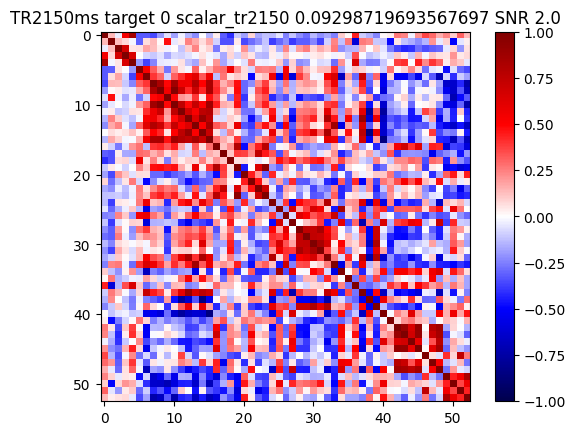

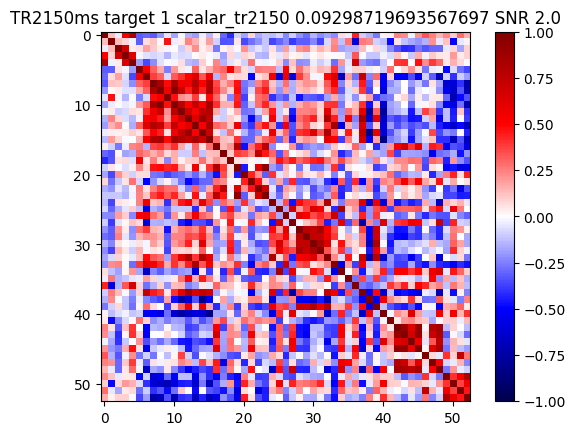

In [8]:
fnc_triu = tr2150_df.iloc[0]['TR2150ms_Window']
fncmat1 = np.zeros((53,53))
fncmat1[np.triu_indices(53)] = fnc_triu
fncmat1 = fncmat1 + fncmat1.T - np.diag(np.diag(fncmat1))
plt.imshow(fncmat1, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = tr2150_df.iloc[0]['target']
plt.title(f'TR2150ms target {target} scalar_tr2150 {scalar_tr2150} SNR {SNR}')
plt.show()

plt.clf()

fnc_triu = tr2150_df.iloc[1]['TR2150ms_Window']
fncmat2 = np.zeros((53,53))
fncmat2[np.triu_indices(53)] = fnc_triu
fncmat2 = fncmat2 + fncmat2.T - np.diag(np.diag(fncmat2))
plt.imshow(fncmat2, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = tr2150_df.iloc[1]['target']
plt.title(f'TR2150ms target {target} scalar_tr2150 {scalar_tr2150} SNR {SNR}')
plt.show()

diff1 = fncmat1 - fncmat2

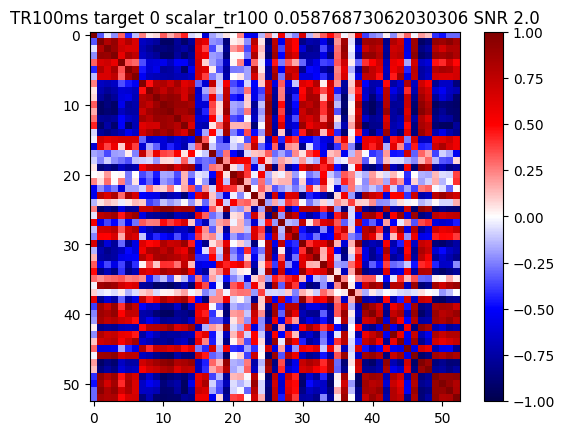

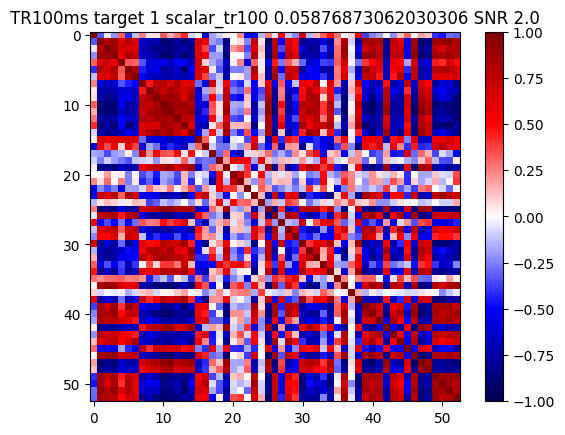

In [9]:
fnc_triu = tr100_df.iloc[0]['TR100ms_Window']
fncmat1 = np.zeros((53,53))
fncmat1[np.triu_indices(53)] = fnc_triu
fncmat1 = fncmat1 + fncmat1.T - np.diag(np.diag(fncmat1))
plt.imshow(fncmat1, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = tr100_df.iloc[0]['target']
plt.title(f'TR100ms target {target} scalar_tr100 {scalar_tr100} SNR {SNR}')
plt.show()

plt.clf()


fnc_triu = tr100_df.iloc[1]['TR100ms_Window']
fncmat2 = np.zeros((53,53))
fncmat2[np.triu_indices(53)] = fnc_triu
fncmat2 = fncmat2 + fncmat2.T - np.diag(np.diag(fncmat2))
plt.imshow(fncmat2, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = tr100_df.iloc[1]['target']
plt.title(f'TR100ms target {target} scalar_tr100 {scalar_tr100} SNR {SNR}')
plt.show()

diff2 = fncmat1 - fncmat2



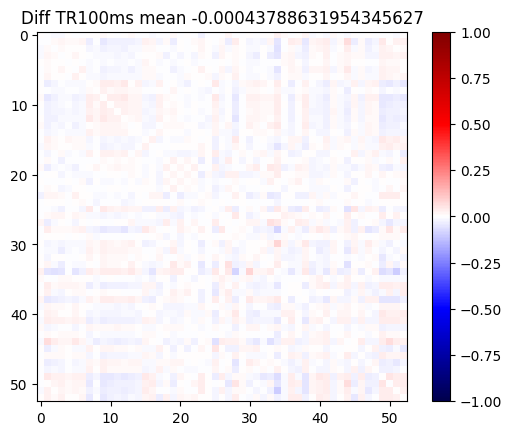

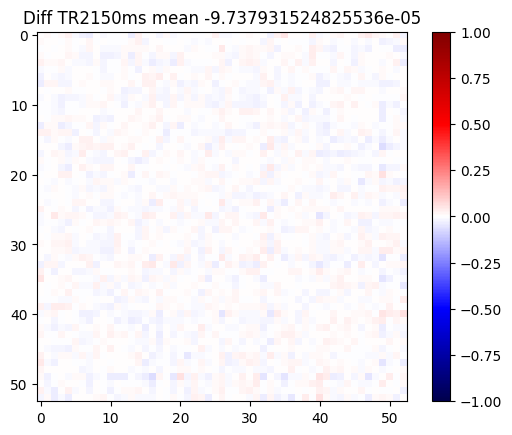

In [10]:
plt.clf()
plt.imshow(diff2, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
plt.title(f'Diff TR100ms mean {np.mean(diff2)}')
plt.show()


plt.clf()
plt.imshow(diff1, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
plt.title(f'Diff TR2150ms mean {np.mean(diff1)}')
plt.show()

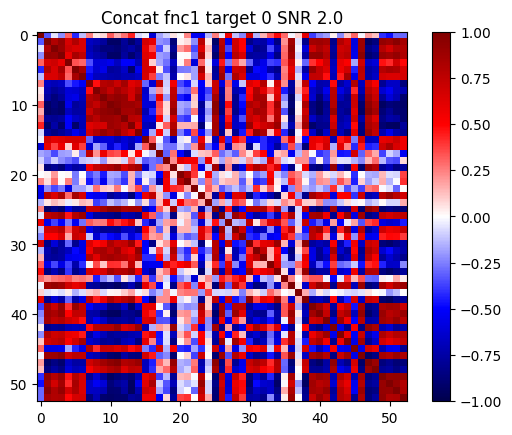

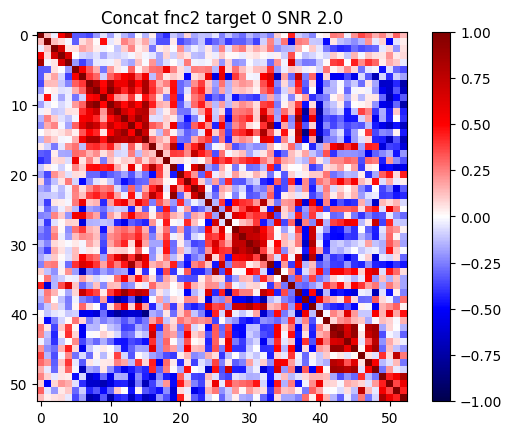

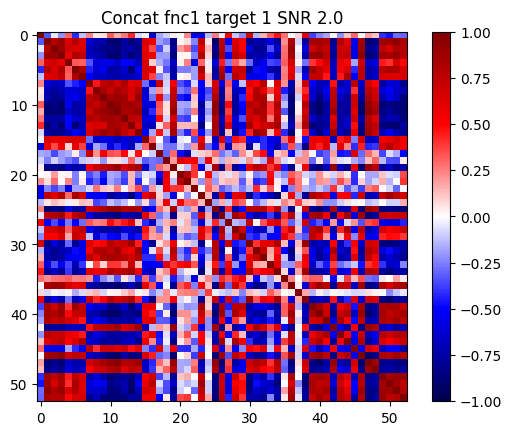

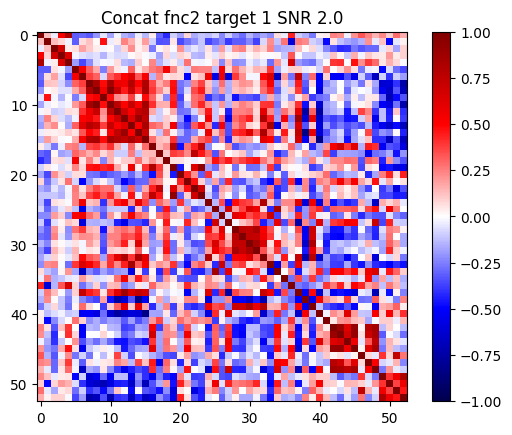

In [11]:
fnc_triu = concat_df.iloc[0]['Concat_Window']
fncmat1 = np.zeros((53,53))
fncmat2 = np.zeros((53,53))
fncmat1[np.triu_indices(53)] = fnc_triu[:1431]
fncmat2[np.triu_indices(53)] = fnc_triu[1431:]
fncmat1 = fncmat1 + fncmat1.T - np.diag(np.diag(fncmat1))
fncmat2 = fncmat2 + fncmat2.T - np.diag(np.diag(fncmat2))
plt.imshow(fncmat1, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = concat_df.iloc[0]['target']
plt.title(f'Concat fnc1 target {target} SNR {SNR}')
plt.show()
plt.clf()

plt.imshow(fncmat2, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = concat_df.iloc[0]['target']
plt.title(f'Concat fnc2 target {target} SNR {SNR}')
plt.show()
plt.clf()

fnc_triu = concat_df.iloc[1]['Concat_Window']
fncmat1 = np.zeros((53,53))
fncmat2 = np.zeros((53,53))
fncmat1[np.triu_indices(53)] = fnc_triu[:1431]
fncmat2[np.triu_indices(53)] = fnc_triu[1431:]
fncmat1 = fncmat1 + fncmat1.T - np.diag(np.diag(fncmat1))
fncmat2 = fncmat2 + fncmat2.T - np.diag(np.diag(fncmat2))
plt.imshow(fncmat1, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = concat_df.iloc[1]['target']
plt.title(f'Concat fnc1 target {target} SNR {SNR}')
plt.show()
plt.clf()

plt.imshow(fncmat2, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = concat_df.iloc[1]['target']
plt.title(f'Concat fnc2 target {target} SNR {SNR}')
plt.show()

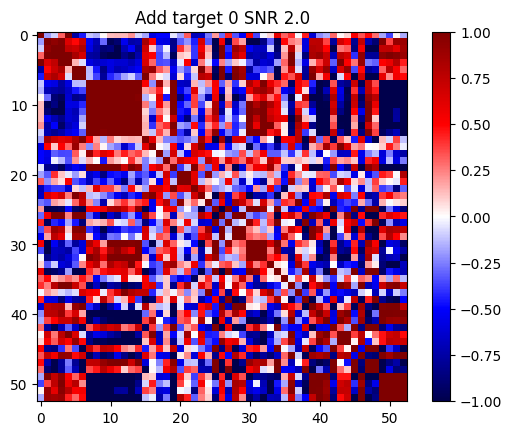

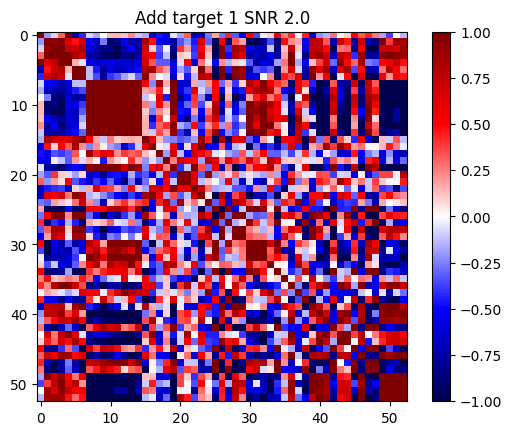

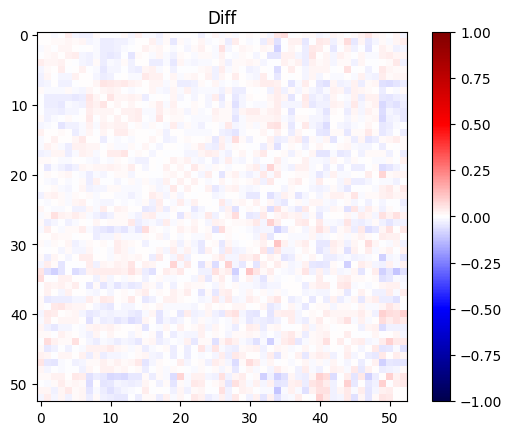

In [12]:
fnc_triu = add_df.iloc[0]['Add_Window']
fncmat1 = np.zeros((53,53))
fncmat1[np.triu_indices(53)] = fnc_triu
fncmat1 = fncmat1 + fncmat1.T - np.diag(np.diag(fncmat1))
plt.imshow(fncmat1, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = add_df.iloc[0]['target']
plt.title(f'Add target {target} SNR {SNR}')
plt.show()
plt.clf()

fnc_triu = add_df.iloc[1]['Add_Window']
fncmat2 = np.zeros((53,53))
fncmat2[np.triu_indices(53)] = fnc_triu
fncmat2 = fncmat2 + fncmat2.T - np.diag(np.diag(fncmat2))
plt.imshow(fncmat2, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = add_df.iloc[1]['target']
plt.title(f'Add target {target} SNR {SNR}')
plt.show()

plt.clf()
plt.imshow(fncmat1 - fncmat2, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()
target = add_df.iloc[1]['target']
plt.title('Diff')
plt.show()


In [13]:
#############################
#   TR=100ms
#############################
logging.info(f'\n\n\n\n START POLYSSIFIER FOR TR=100ms snr {SNR} noise_ix {noise_ix}')
group_tr100 = tr100_df['subject']
y_tr100 = tr100_df['target']
y_tr100 = np.array([str(entry) for entry in y_tr100])
X_tr100 = tr100_df['TR100ms_Window']
X_tr100 = np.array([np.array(entry) for entry in X_tr100])

res1 = []
report1 = poly(data=X_tr100, label=y_tr100, groups=group_tr100, n_folds=n_folds, scale=True, concurrency=n_threads, save=False, 
                exclude=['Decision Tree', 'Random Forest', 'Voting', 'Nearest Neighbors', 'Linear SVM'],  scoring='auc')

for classifier in report1.scores.columns.levels[0]:
            if classifier == 'Voting':
                continue

            res1.append({'graph_no': graph_ix,
                            'nstd': nstd,
                            'burnin': burn,
                            'noise_no': noise_ix,
                            'snr': SNR,
                            'classifier': classifier,
                            'test_scores': report1.scores[classifier, 'test'], 
                            'target': report1.target, 
                            'predictions': np.array(report1.predictions[classifier]).astype(int),
                            'test_proba': report1.test_proba[classifier]})

            logging.info(report1.scores[classifier, 'test'])

df1 = pd.DataFrame(res1)  

df1.to_pickle(f'/data/users2/jwardell1/undersampling-project/OULU/pkl-files/sr1_{SNR}_{graph_ix}.pkl')      # write SR1 dataframe to disk as pickle

df1

2024-05-10 01:07:54,630 - INFO - 



 START POLYSSIFIER FOR TR=100ms snr 2.0 noise_ix 0
2024-05-10 01:07:54,665 - INFO - Detected 2 classes in label
2024-05-10 01:07:54,666 - INFO - Building classifiers ...
2024-05-10 01:07:54,673 - INFO - Initialization, done.
2024-05-10 01:07:54,674 - INFO - Detected 10 unique groups


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


2024-05-10 01:07:56,215 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-10 01:07:56,219 - INFO - Training Multilayer Perceptron 1
2024-05-10 01:07:56,269 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-10 01:07:56,272 - INFO - Training Multilayer Perceptron 0
2024-05-10 01:07:56,371 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-10 01:07:56,391 - INFO - Training Multilayer Perceptron 2
2024-05-10 01:07:58,000 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-10 01:07:58,019 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-10 01:07:58,027 - INFO - Training Multilayer Perceptron 3
2024-05-10 01:07:58,046 - INFO - Training SVM 0
2024-05-10 01:07:58,252 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-10 01:07:58,245 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-10 01:07:58,286 - INFO - Training SVM 2
2024-05-10 01:07:58,299 - INFO - Training Logistic Regression 0
2024-05-10 01:07:58,691 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-10 01:07:58,720

2024-05-09 22:16:45,584 - INFO - 



 START POLYSSIFIER FOR TR=2150ms snr 2.0 scalar 0.1 noise_ix 0
2024-05-09 22:16:45,622 - INFO - Detected 2 classes in label
2024-05-09 22:16:45,623 - INFO - Building classifiers ...
2024-05-09 22:16:45,629 - INFO - Initialization, done.
2024-05-09 22:16:45,631 - INFO - Detected 10 unique groups


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


2024-05-09 22:16:47,167 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 22:16:47,171 - INFO - Training Multilayer Perceptron 1
2024-05-09 22:16:47,312 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-09 22:16:47,324 - INFO - Training Multilayer Perceptron 3
2024-05-09 22:16:47,595 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 22:16:47,634 - INFO - Training Multilayer Perceptron 0
2024-05-09 22:16:47,844 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 22:16:47,883 - INFO - Training SVM 1
2024-05-09 22:16:48,041 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 22:16:48,097 - INFO - Training Logistic Regression 0
2024-05-09 22:16:48,078 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-09 22:16:48,127 - INFO - Training SVM 2
2024-05-09 22:16:48,132 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-09 22:16:48,158 - INFO - Training Multilayer Perceptron 2
2024-05-09 22:16:48,242 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 22:16:48,300

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.571121  0.043243  0.538993  0.634453
SVM                   train  0.857017  0.038679  0.808885  0.903592
                      test   0.539856  0.027832  0.501753  0.567383
Logistic Regression   train  1.000000  0.000000  1.000000  1.000000
                      test   0.578772  0.039009  0.541910  0.625703
Naive Bayes           train  0.662302  0.016558  0.651445  0.686974
                      test   0.571808  0.039315  0.537049  0.624948
Voting                train  0.925698  0.044993  0.889844  0.990179
                      test   0.504687  0.005984  0.500000  0.512500


,graph_no,nstd,burnin,noise_no,snr,scalar,classifier,test_scores,target,predictions,test_proba
0,1002,1.0,100,0,2.0,0.1,Logistic Regression,0 0.55191 1 0.595566 2 0.54191 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 0.999954 1 0.999981 2 0.99...
1,1002,1.0,100,0,2.0,0.1,Multilayer Perceptron,0 0.549201 1 0.561836 2 0.538993 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 0.999992 1 0.999994 2 0.99...
2,1002,1.0,100,0,2.0,0.1,Naive Bayes,0 0.624948 1 0.547852 2 0.537049 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 0.978446 1 0.988020 2 0.97...
3,1002,1.0,100,0,2.0,0.1,SVM,0 0.501753 1 0.550547 2 0.53974 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 0.761495 1 0.761873 2 0.76...


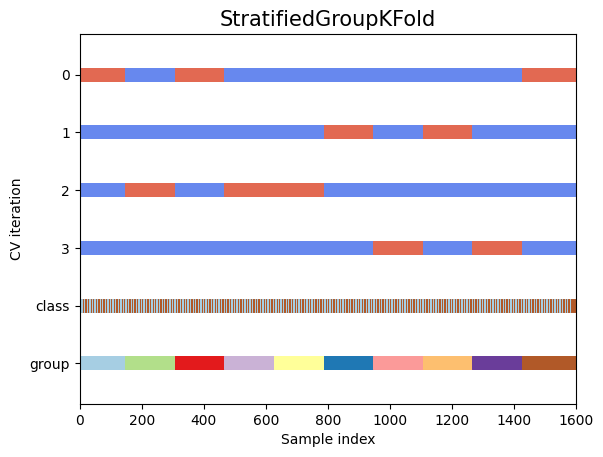

In [ ]:
#############################
#   TR=2150ms
#############################
logging.info(f'\n\n\n\n START POLYSSIFIER FOR TR=2150ms snr {SNR} noise_ix {noise_ix}')
group_tr2150 = tr2150_df['subject']
y_tr2150 = tr2150_df['target']
y_tr2150 = np.array([str(entry) for entry in y_tr2150])
X_tr2150 = tr2150_df['TR2150ms_Window']
X_tr2150 = np.array([np.array(entry) for entry in X_tr2150])

res2 = []
report2 = poly(data=X_tr2150, label=y_tr2150, groups=group_tr2150, n_folds=n_folds, scale=True, concurrency=n_threads, save=False, 
                exclude=['Decision Tree', 'Random Forest', 'Voting', 'Nearest Neighbors', 'Linear SVM'],  scoring='auc')

for classifier in report2.scores.columns.levels[0]:                                                                                         # iterate through all classifiers in the report
            if classifier == 'Voting':
                continue

            res2.append({'graph_no': graph_ix,                                                                                                      # save the SR1 results to a dict for results dataframe
                            'nstd': nstd,
                            'burnin': burn,
                            'noise_no': noise_ix,
                            'snr': SNR,
                            'classifier': classifier,
                            'test_scores': report2.scores[classifier, 'test'], 
                            'target': report2.target, 
                            'predictions': np.array(report2.predictions[classifier]).astype(int),
                            'test_proba': report2.test_proba[classifier]})

            logging.info(report2.scores[classifier, 'test'])


df2 = pd.DataFrame(res2)

df2.to_pickle(f'/data/users2/jwardell1/undersampling-project/OULU/pkl-files/sr2_{SNR}_{graph_ix}.pkl')      # write SR2 dataframe to disk as pickle

df2



2024-05-09 22:20:21,620 - INFO - 



 START POLYSSIFIER FOR CONCAT snr 2.0 scalar 0.1 noise_ix 0
2024-05-09 22:20:21,674 - INFO - Detected 2 classes in label
2024-05-09 22:20:21,675 - INFO - Building classifiers ...
2024-05-09 22:20:21,681 - INFO - Initialization, done.
2024-05-09 22:20:21,683 - INFO - Detected 10 unique groups


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


2024-05-09 22:20:24,359 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-09 22:20:24,364 - INFO - Training Multilayer Perceptron 3
2024-05-09 22:20:25,012 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 22:20:25,024 - INFO - Training Multilayer Perceptron 0
2024-05-09 22:20:25,728 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-09 22:20:25,747 - INFO - Training SVM 2
2024-05-09 22:20:26,179 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 22:20:26,199 - INFO - Training SVM 0
2024-05-09 22:20:26,629 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 22:20:26,643 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-09 22:20:26,654 - INFO - Training Multilayer Perceptron 1
2024-05-09 22:20:26,657 - INFO - Training Multilayer Perceptron 2
2024-05-09 22:20:26,663 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 22:20:26,688 - INFO - Training SVM 1
2024-05-09 22:20:29,094 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 22:20:29,119 - INFO - Traini

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.678325  0.102795  0.555260  0.786788
SVM                   train  0.964700  0.016724  0.948604  0.985403
                      test   0.666192  0.029749  0.635573  0.706597
Logistic Regression   train  0.999393  0.001213  0.997573  1.000000
                      test   0.653194  0.081069  0.552839  0.749023
Naive Bayes           train  0.565592  0.038205  0.537559  0.621258
                      test   0.653704  0.053891  0.585521  0.715352
Voting                train  0.943722  0.044259  0.891964  1.000000
                      test   0.567448  0.068925  0.500000  0.662500


,graph_no,nstd,burnin,noise_no,snr,scalar,classifier,test_scores,target,predictions,test_proba
0,1002,1.0,100,0,2.0,0.1,Logistic Regression,0 0.670486 1 0.64043 2 0.552839 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 1.0 1 1.0 2 1.0 3 1....
1,1002,1.0,100,0,2.0,0.1,Multilayer Perceptron,0 0.786788 1 0.637227 2 0.55526 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 1.0 1 1.0 2 1.0 3 1....
2,1002,1.0,100,0,2.0,0.1,Naive Bayes,0 0.667969 1 0.645977 2 0.585521 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 2.787685e-151 1 8.394149e-129 2 ...
3,1002,1.0,100,0,2.0,0.1,SVM,0 0.706597 1 0.656992 2 0.635573 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 0.037009 1 0.045115 2 0.03...


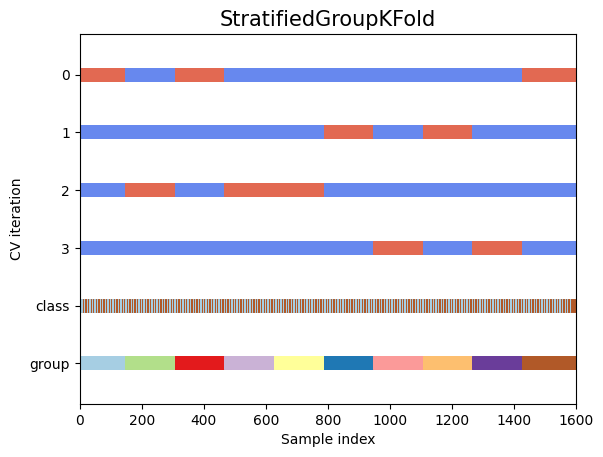

In [ ]:

#############################
#   CONCAT
#############################
logging.info(f'\n\n\n\n START POLYSSIFIER FOR CONCAT snr {SNR} noise_ix {noise_ix}')
group_concat = concat_df['subject']
y_concat = concat_df['target']
y_concat = np.array([str(entry) for entry in y_concat])
X_concat = concat_df['Concat_Window']
X_concat = np.array([np.array(entry) for entry in X_concat])

res3 = []
report3 = poly(data=X_concat, label=y_concat, groups=group_concat, n_folds=n_folds, scale=True, concurrency=n_threads, save=False, 
                exclude=['Decision Tree', 'Random Forest', 'Voting', 'Nearest Neighbors', 'Linear SVM'],  scoring='auc')

for classifier in report3.scores.columns.levels[0]:                                                                                         # iterate through all classifiers in the report
            if classifier == 'Voting':
                continue

            res3.append({'graph_no': graph_ix,                                                                                                      # save the SR1 results to a dict for results dataframe
                            'nstd': nstd,
                            'burnin': burn,
                            'noise_no': noise_ix,
                            'snr': SNR,
                            'classifier': classifier,
                            'test_scores': report3.scores[classifier, 'test'], 
                            'target': report3.target, 
                            'predictions': np.array(report3.predictions[classifier]).astype(int),
                            'test_proba': report3.test_proba[classifier]})

            logging.info(report3.scores[classifier, 'test'])


df3 = pd.DataFrame(res3)                                                                                    # save CONCAT results as dataframe

df3.to_pickle(f'/data/users2/jwardell1/undersampling-project/OULU/pkl-files/concat_{SNR}_{graph_ix}.pkl')   # write CONCAT dataframe to disk as pickle

df3



2024-05-09 22:26:48,144 - INFO - 



 START POLYSSIFIER FOR ADD snr 2.0 scalar 0.1 noise_ix 0
2024-05-09 22:26:48,171 - INFO - Detected 2 classes in label
2024-05-09 22:26:48,172 - INFO - Building classifiers ...
2024-05-09 22:26:48,180 - INFO - Initialization, done.
2024-05-09 22:26:48,181 - INFO - Detected 10 unique groups


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


2024-05-09 22:26:49,595 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 22:26:49,599 - INFO - Training Multilayer Perceptron 0
2024-05-09 22:26:49,909 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 22:26:49,918 - INFO - Training Multilayer Perceptron 1
2024-05-09 22:26:50,004 - INFO - Group Train: {0, 1, 2, 4, 5, 6, 8, 9}
2024-05-09 22:26:50,023 - INFO - Training Multilayer Perceptron 3
2024-05-09 22:26:50,186 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-09 22:26:50,245 - INFO - Training Multilayer Perceptron 2
2024-05-09 22:26:50,557 - INFO - Group Train: {1, 2, 3, 5, 6, 7, 8}
2024-05-09 22:26:50,626 - INFO - Training SVM 0
2024-05-09 22:26:50,578 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 22:26:50,653 - INFO - Training SVM 1
2024-05-09 22:26:50,758 - INFO - Group Train: {0, 1, 3, 4, 5, 7, 9}
2024-05-09 22:26:50,759 - INFO - Group Train: {0, 2, 3, 4, 6, 7, 8, 9}
2024-05-09 22:26:50,814 - INFO - Training Logistic Regression 1
2024-05-09 22:26:50,

                                 mean       std       min       max
Multilayer Perceptron train  1.000000  0.000000  1.000000  1.000000
                      test   0.665090  0.100114  0.541597  0.773507
SVM                   train  0.970344  0.015417  0.956888  0.990883
                      test   0.662331  0.019221  0.649375  0.690833
Logistic Regression   train  0.992567  0.004465  0.988453  0.998892
                      test   0.673372  0.062659  0.599826  0.745117
Naive Bayes           train  0.603396  0.030012  0.577721  0.644324
                      test   0.631352  0.016051  0.607656  0.642266
Voting                train  0.933929  0.038731  0.889286  0.983594
                      test   0.524479  0.037514  0.500000  0.579167


,graph_no,nstd,burnin,noise_no,snr,scalar,classifier,test_scores,target,predictions,test_proba
0,1002,1.0,100,0,2.0,0.1,Logistic Regression,0 0.698976 1 0.64957 2 0.599826 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 0.979664 1 0.985376 2 0.98...
1,1002,1.0,100,0,2.0,0.1,Multilayer Perceptron,0 0.773507 1 0.634219 2 0.541597 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0 1.000000 1 1.000000 2 1.00...
2,1002,1.0,100,0,2.0,0.1,Naive Bayes,0 0.635434 1 0.607656 2 0.640052 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 1.297944e-33 1 4.436800e-27 2 ...
3,1002,1.0,100,0,2.0,0.1,SVM,0 0.690833 1 0.649375 2 0.656458 3 ...,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0 0.038186 1 0.050198 2 0.03...


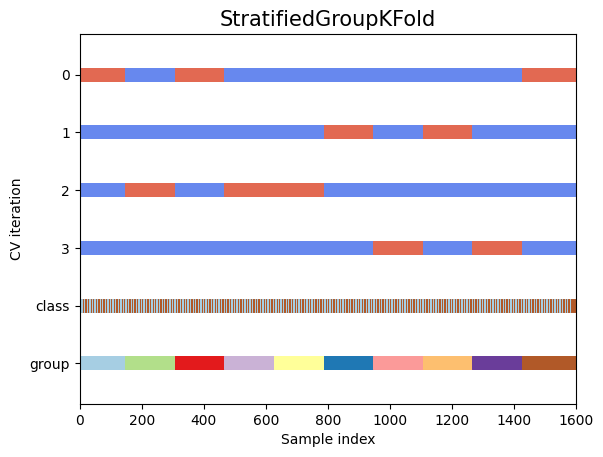

In [ ]:
#############################
#   ADD
#############################
logging.info(f'\n\n\n\n START POLYSSIFIER FOR ADD snr {SNR} noise_ix {noise_ix}')
group_add = add_df['subject']
y_add = add_df['target']
y_add = np.array([str(entry) for entry in y_add])
X_add = add_df['Add_Window']
X_add = np.array([np.array(entry) for entry in X_add])

res4 = []
report4 = poly(data=X_add, label=y_add, groups=group_add, n_folds=n_folds, scale=True, concurrency=n_threads, save=False, 
                exclude=['Decision Tree', 'Random Forest', 'Voting', 'Nearest Neighbors', 'Linear SVM'],  scoring='auc')

for classifier in report4.scores.columns.levels[0]:                                                                                         # iterate through all classifiers in the report
            if classifier == 'Voting':
                continue

            res4.append({'graph_no': graph_ix,                                                                                                      # save the SR1 results to a dict for results dataframe
                            'nstd': nstd,
                            'burnin': burn,
                            'noise_no': noise_ix,
                            'snr': SNR,
                            'classifier': classifier,
                            'test_scores': report4.scores[classifier, 'test'], 
                            'target': report4.target, 
                            'predictions': np.array(report4.predictions[classifier]).astype(int),
                            'test_proba': report4.test_proba[classifier]})

            logging.info(report4.scores[classifier, 'test'])



df4 = pd.DataFrame(res4)                                                                                    # save ADD results as dataframe

df4.to_pickle(f'/data/users2/jwardell1/undersampling-project/OULU/pkl-files/add_{SNR}_{graph_ix}.pkl')      # write ADD dataframe to disk as pickle

df4

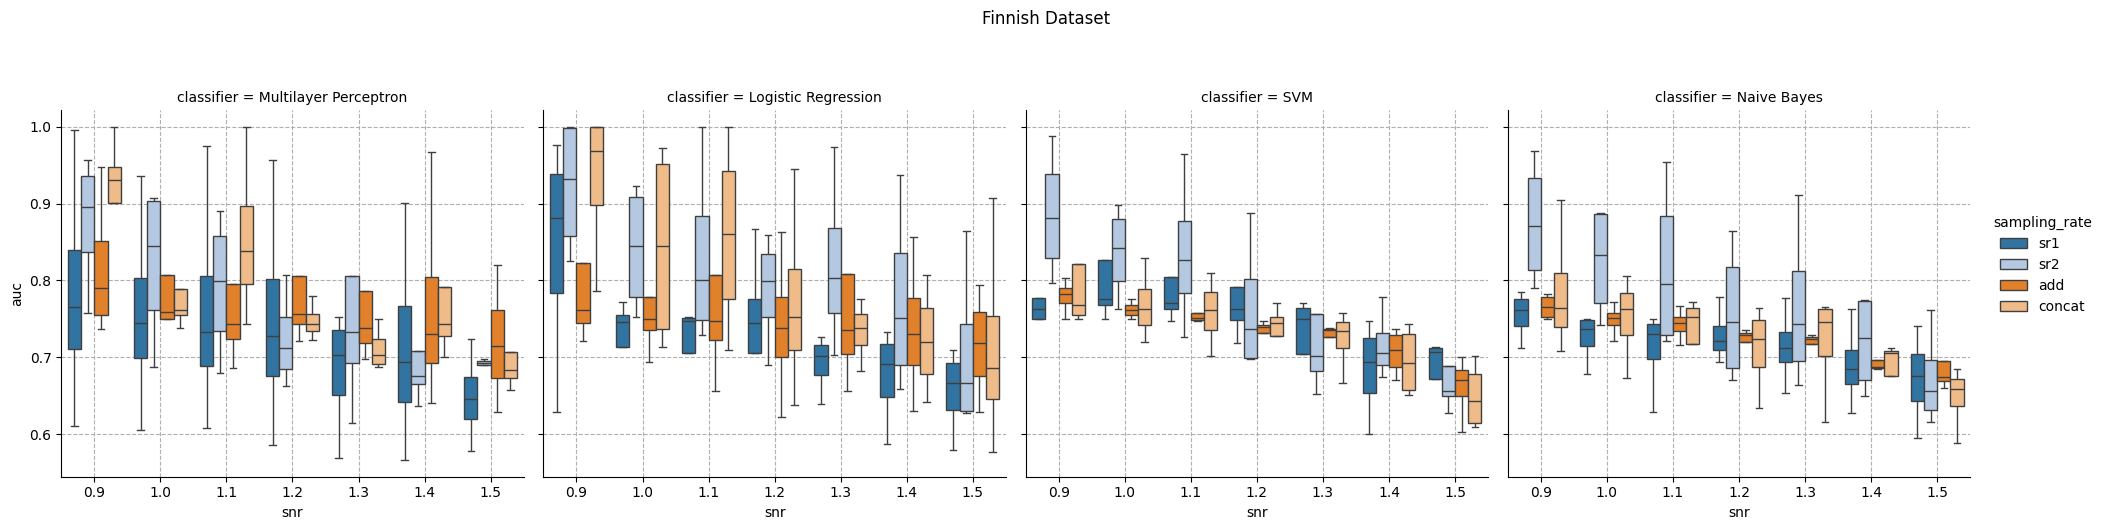

In [8]:
import pandas as pd
import os
import glob
import matplotlib.ticker as ticker # type: ignore
from statannot import add_stat_annotation


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import numpy as np
import os
from matplotlib.ticker import MaxNLocator

from sklearn.metrics import roc_curve, auc

import os
import glob
import pandas as pd

pkl_dir = '/data/users2/jwardell1/undersampling-project/OULU/pkl-files/2'

# Read and concatenate sr1 data
joined_files = os.path.join(pkl_dir, 'sr1_*.pkl')
joined_list = glob.glob(joined_files)
sr1 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr1') for file in joined_list), ignore_index=True)

# Read and concatenate sr2 data
joined_files = os.path.join(pkl_dir, 'sr2_*.pkl')
joined_list = glob.glob(joined_files)
sr2 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr2') for file in joined_list), ignore_index=True)

# Read and concatenate concat data
joined_files = os.path.join(pkl_dir, 'concat_*.pkl')
joined_list = glob.glob(joined_files)
concat = pd.concat((pd.read_pickle(file).assign(sampling_rate='concat') for file in joined_list), ignore_index=True)

# Read and concatenate add data
joined_files = os.path.join(pkl_dir, 'add_*.pkl')
joined_list = glob.glob(joined_files)
add = pd.concat((pd.read_pickle(file).assign(sampling_rate='add') for file in joined_list), ignore_index=True)

# Concatenate all dataframes
all_data = pd.concat([sr1, sr2, concat, add], ignore_index=True)

import pandas as pd

# Function to split each row into multiple rows based on cross-validation index
def split_row(row):
    new_rows = []
    for cv_ix, auc in enumerate(row['test_scores']):
        new_row = row.copy()
        new_row['auc'] = auc
        new_row['cv_ix'] = cv_ix
        new_rows.append(new_row)
    return pd.DataFrame(new_rows)

# Apply the split_row function to each row of the dataframe and concatenate the results
result_df = pd.concat(all_data.apply(split_row, axis=1).tolist(), ignore_index=True)



# Drop the original 'test_scores' column as it's no longer needed
result_df.drop('test_scores', axis=1, inplace=True)



grouped_classifiers = result_df.groupby('classifier')


classifier_dfs = {}
for classifier, group_df in grouped_classifiers:
    classifier_dfs[classifier] = group_df.copy()

mlp_df = classifier_dfs['Multilayer Perceptron']
lr_df = classifier_dfs['Logistic Regression']
svm_df = classifier_dfs['SVM']
nb_df = classifier_dfs['Naive Bayes']

import seaborn as sns
import matplotlib.pyplot as plt


dfs = [mlp_df, lr_df, svm_df, nb_df]
classifiers = ['Multilayer Perceptron', 'Logistic Regression', 'SVM', 'Naive Bayes']
sampling_rates = ['sr1', 'sr2', 'add', 'concat']
hue_order = sampling_rates
palette = { item: plt.cm.tab20(i) for i, item in enumerate(sampling_rates)}

# Combine all dataframes into one dataframe for plotting
combined_df = pd.concat(dfs)

#snr_levels = [0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.0 , 1.1 , 1.2 , 1.3 , 1.4 , 1.5 , 1.6 , 1.7 , 1.8 , 1.9 , 2.0]
snr_levels = [ 0.9 , 1.0 , 1.1 , 1.2 , 1.3 , 1.4 , 1.5]






# Plot all boxplots in one plot using catplot
ax = sns.catplot(
    x="snr", 
    order=snr_levels,
    y="auc",
    hue="sampling_rate",
    hue_order=hue_order,
    col="classifier",
    data=combined_df,
    kind="box",
    palette=palette,
    showfliers=False
)
# Set the title of the main plot with some padding
ax.fig.suptitle("Finnish Dataset", y=1.05)

# Adjust the spacing between the main title and the columns
plt.subplots_adjust(top=0.85)
for axes in ax.axes.flat:
    axes.grid(True, which='both', axis='both', linestyle='--')

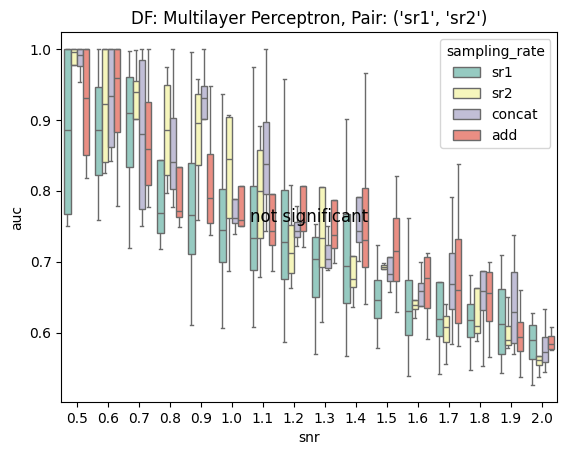

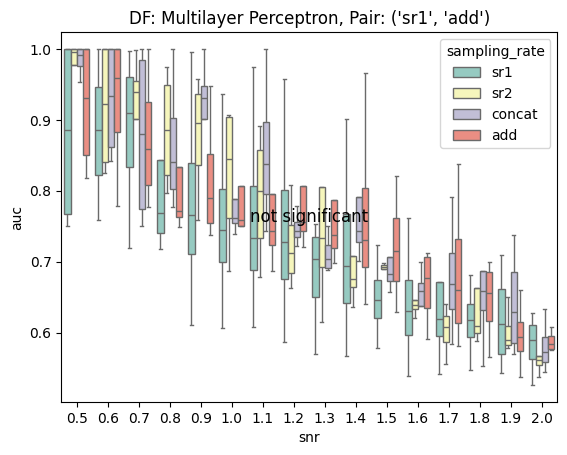

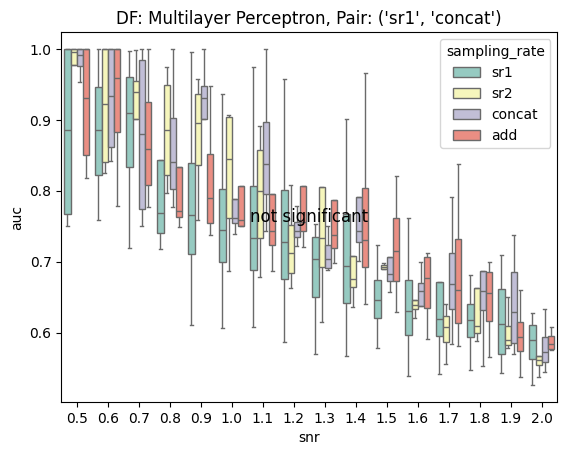

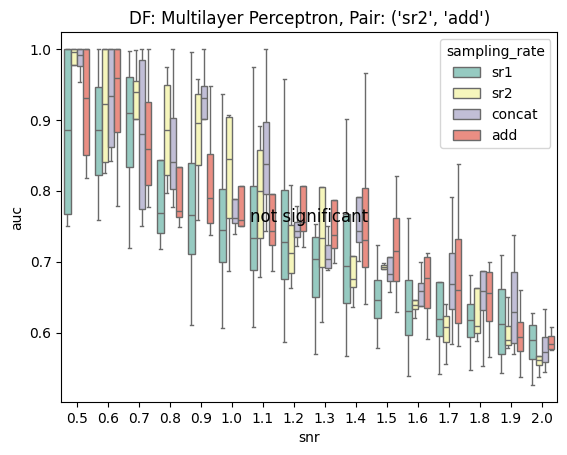

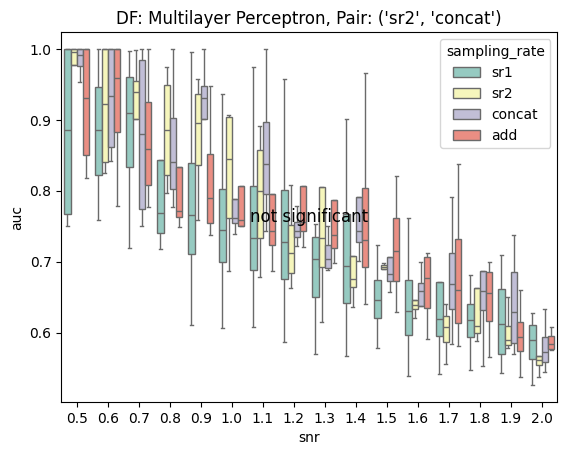

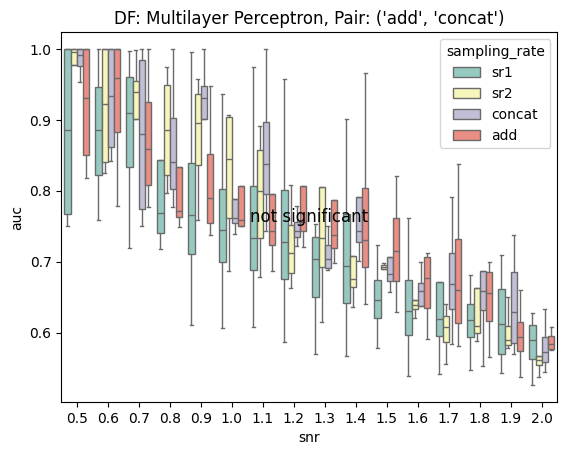

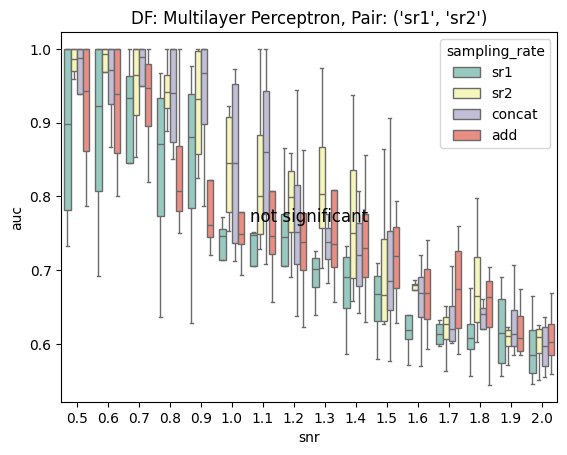

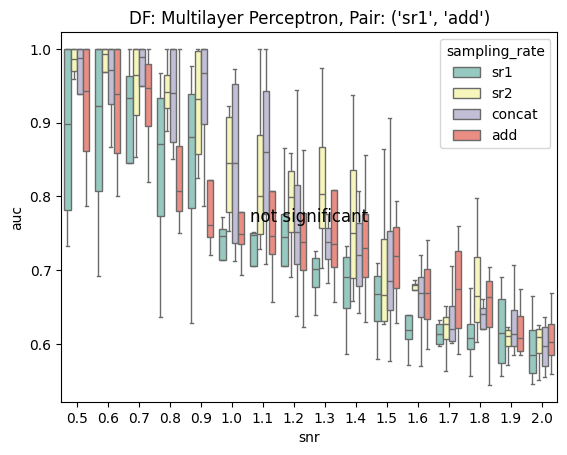

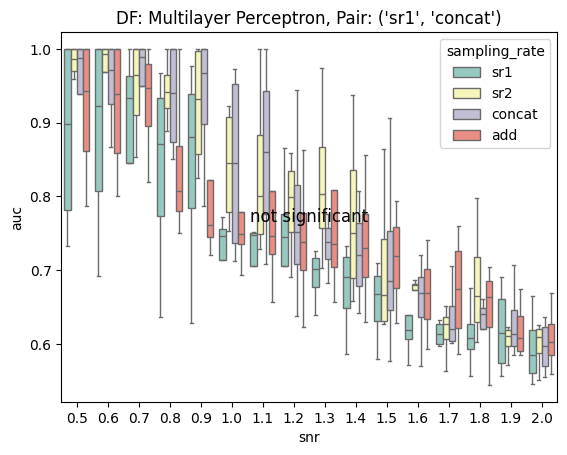

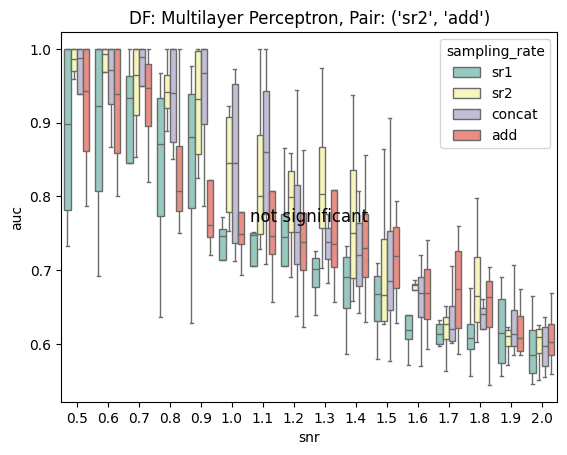

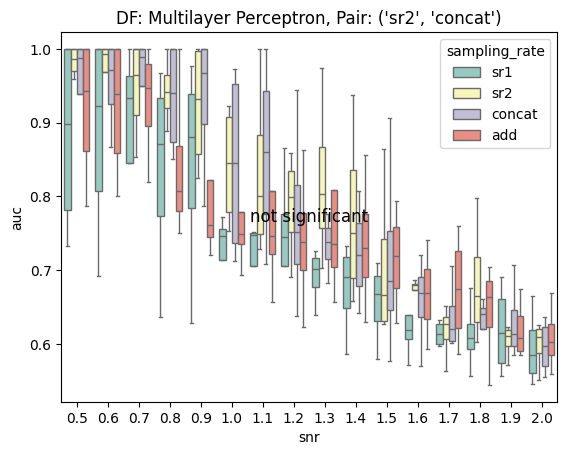

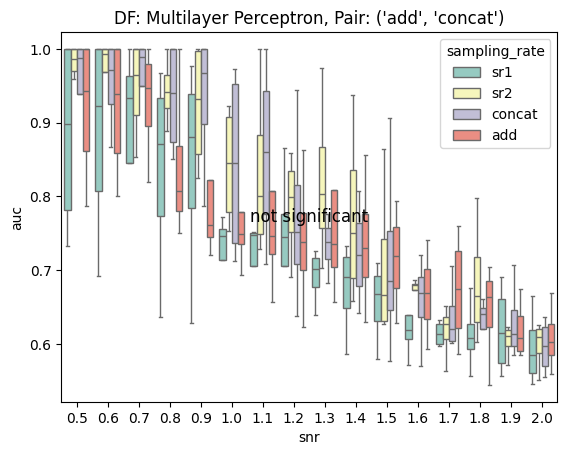

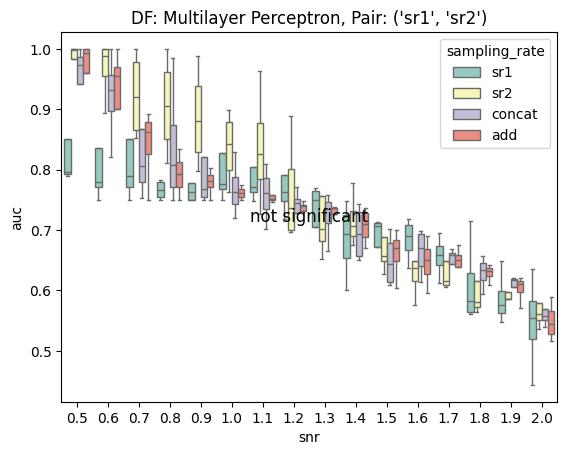

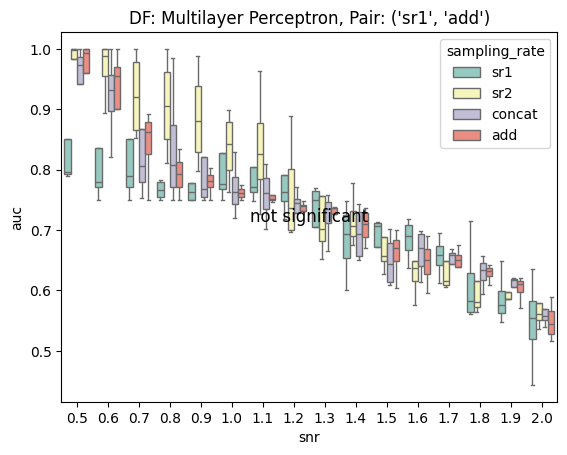

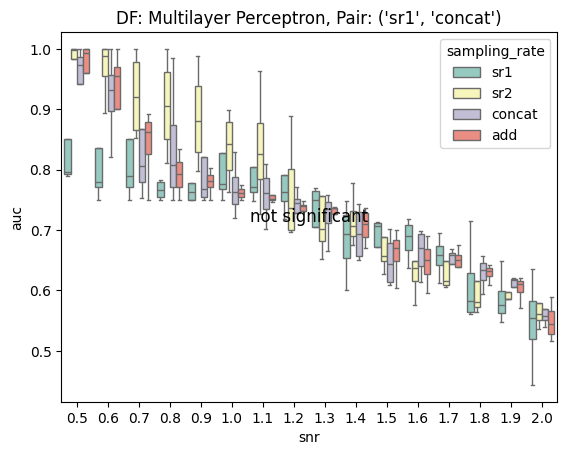

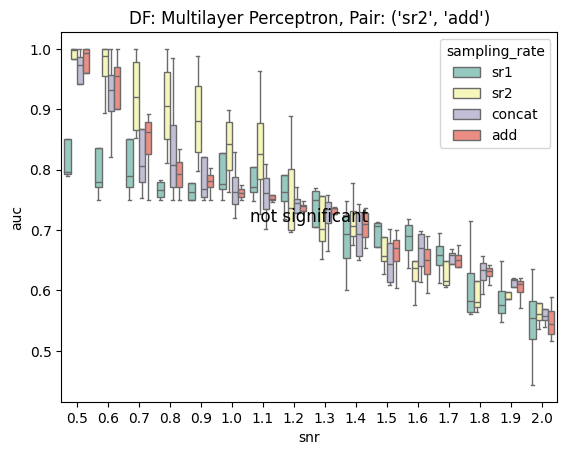

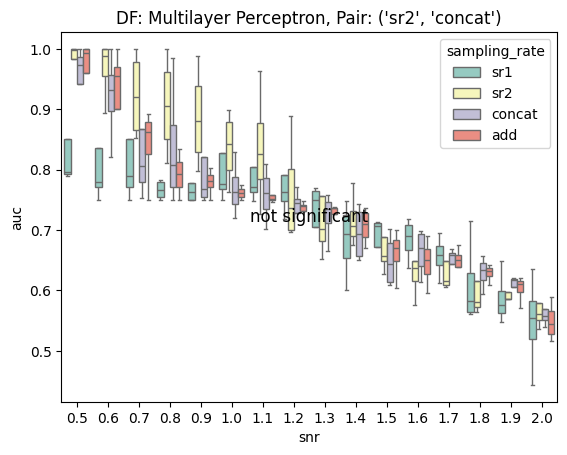

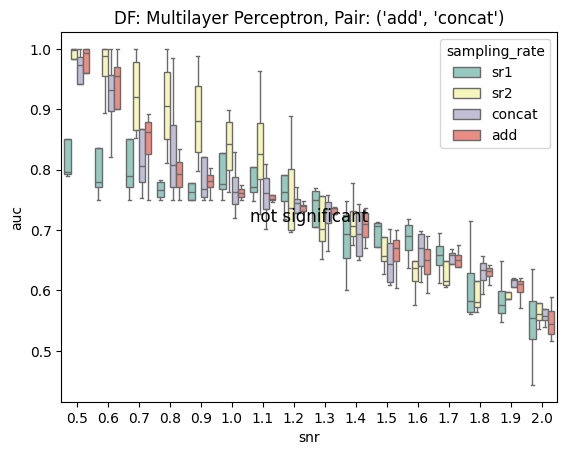

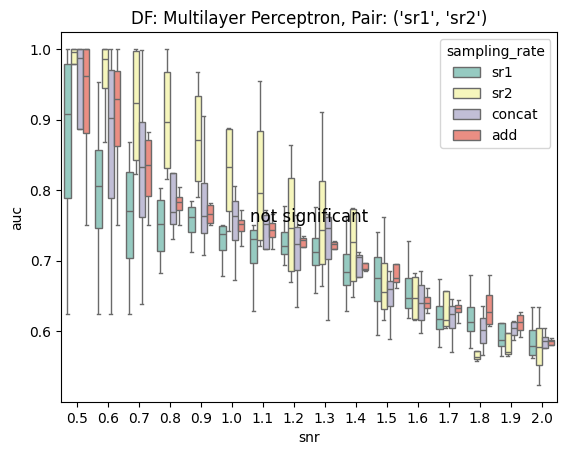

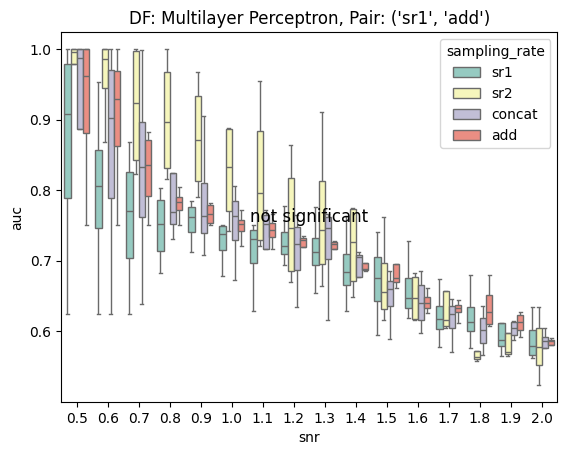

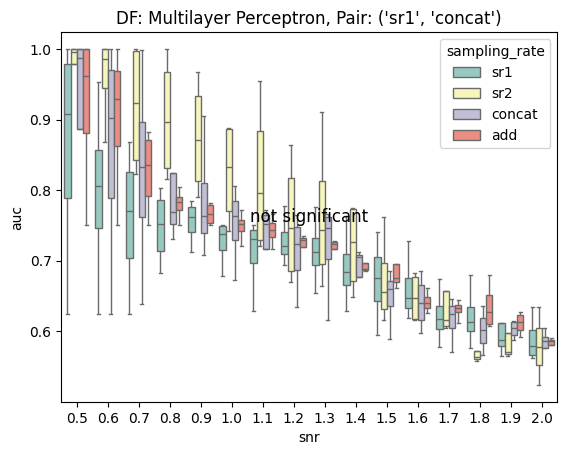

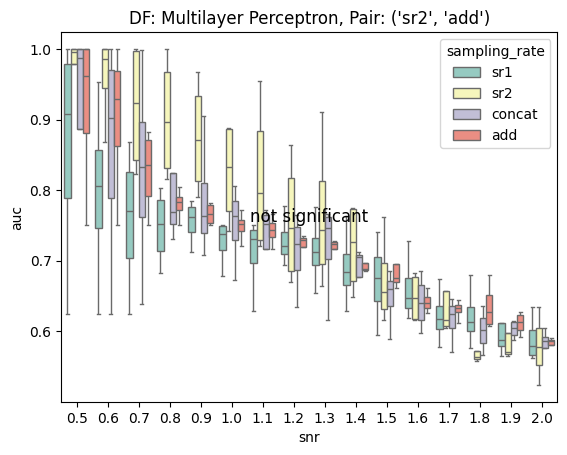

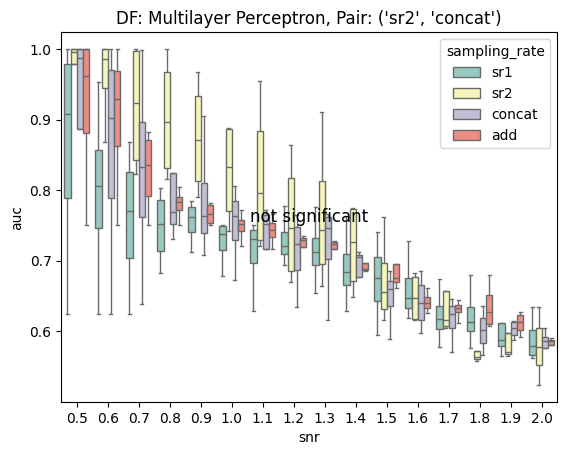

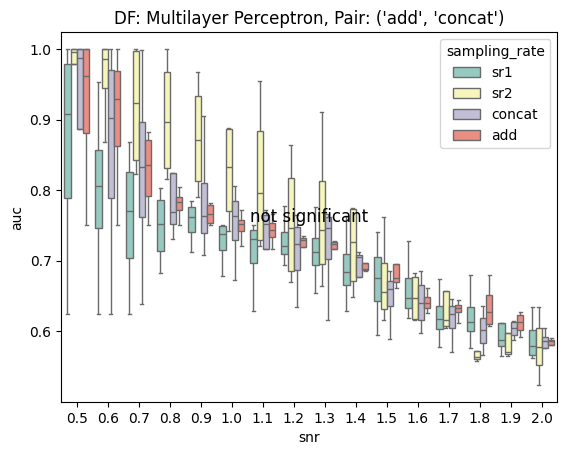

In [7]:
from itertools import combinations
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Define all sampling rates
sampling_rates = ['sr1', 'sr2', 'add', 'concat']
dfs = [mlp_df, lr_df, svm_df, nb_df]
df_name = ['Multilayer Perceptron', 'Logistic Regression', 'SVM', 'Naive Bayes']
# Get all possible combinations of pairs
pairs = list(combinations(sampling_rates, 2))



# Iterate over all dataframes
for df in dfs:
    ix = 0
    # Filter the dataframe for snr values in the range [1.5, 2]
    filtered_df = df[df["snr"].astype(float).between(0.5, 2)]
    
    # Define the p-value annotation legend
    pvalue_legend = {'ns': '5.00e-02 < p <= 1.00e+00',
                     '*': '1.00e-02 < p <= 5.00e-02',
                     '**': '1.00e-03 < p <= 1.00e-02',
                     '***': '1.00e-04 < p <= 1.00e-03',
                     '****': 'p <= 1.00e-04'}

    # Perform t-test and annotate the plot for each pair
    for pair in pairs:
        # Filter the dataframe for the two sampling rates
        filtered_df1 = filtered_df[filtered_df["sampling_rate"] == pair[0]]
        filtered_df2 = filtered_df[filtered_df["sampling_rate"] == pair[1]]
        # Perform t-test and get p-value
        t_statistic, p_value = stats.ttest_ind(filtered_df1["auc"], filtered_df2["auc"])
        # Get the corresponding annotation or set it to "not significant" if not found
        pvalue_annotation = pvalue_legend.get(p_value, "not significant")

        # Plot the boxplot
        sns.boxplot(x="snr", y="auc", hue="sampling_rate", data=filtered_df, palette="Set3", showfliers=False)
        # Annotate the plot with p-value
        plt.text(0.5, 0.5, pvalue_annotation, fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f'DF: {df_name[ix]}, Pair: {pair}')
        # Show the plot
        plt.show()
    ix += 1
